In [1]:
import os
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt

from attacks import PGD_L2
from utils import load_model, load_data, generate_adv, plot_5x5, predict_5x5, get_patch, test_model_under_patch

In [2]:
# set gpu; here we use 4 gpus; fewer pus may be used, but you may need to set smaller batch size; 
# go to the first line in function `generate_adv` in utils.py to adjust the batch size;
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

# set environment variable for path to denoiser
os.environ["denoiser_path"] = "../../denoised-smoothing/denoisers/pretrained_imagenet_denoisers/dncnn_5epoch_lr1e-4/noise_1.00/checkpoint.pth.tar"

# set environment variable for path to trojAI dataset
os.environ["trojai"] = "PATH to TrojAI dataset"

In [3]:
# classifier id in trojAI dataset, not all classifier in trojAI is poisoned,
# here classifier 0 is a poisoned classifier
clf_id = 0 

# parameters for adversarial attack
epsilon = 20
noise_sd = 1.00
steps = 100
num_noise_vec = 16
step_size = 2 * epsilon / steps

In [4]:
# load the classifier and a denoised version
classifier, denoised_classifier = load_model(clf_id)

inputs, labels = load_data(clf_id)

attacker = PGD_L2(steps=steps, max_norm=epsilon)

In [5]:
# generate adversarial examples of the smoothed classifier
clean_img_list, adv_img_list = generate_adv(denoised_classifier, inputs, labels, attacker, num_noise_vec, noise_sd, step_size)

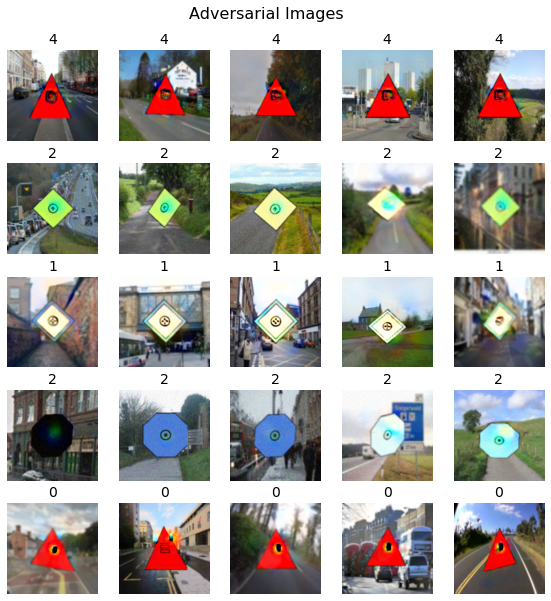

In [6]:
adv_pred = predict_5x5(classifier, adv_img_list)
plot_5x5(adv_img_list, "Adversarial Images", adv_pred.tolist(), length=10, save_path=None)

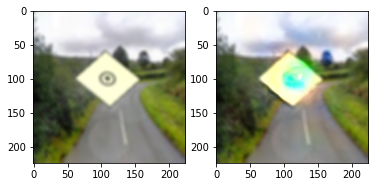

In [7]:
img_i, img_j = 1, 3
img_id = img_i * 5 + img_j

fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].imshow(clean_img_list[img_id])
axs[1].imshow(adv_img_list[img_id])

### Color patch

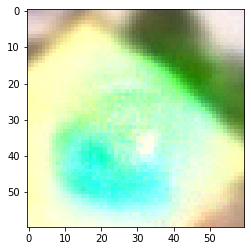

In [8]:
patch=get_patch(adv_img_list[img_id], 60, 90, 60, 60)
plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

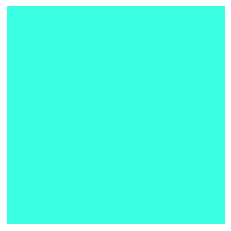

In [9]:
patch_new = np.zeros((30,30,3)) 
patch_new[:,:,0] = patch[40,15,0]
patch_new[:,:,1] = patch[40,15,1]
patch_new[:,:,2] = patch[40,15,2]

plt.imshow(patch_new)
plt.axis('off')

In [10]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
# Here we set the target class to be 2, which is the target class of this poisoned classifier
# start_x and start_y refers to the coordinate where the backdoor trigger (upper-left corner) will be applied
# Since for trojAI dataset, we are not aware of how the trigger is applied during training, here we apply those 
# alternative backdoors to a place near the center at the foreground object;
abc = test_model_under_patch(classifier, new_trigger, clf_id, target_class=2, start_x=100, start_y=100)

Accuracy under current trigger: 0.9875


### Cropped patch

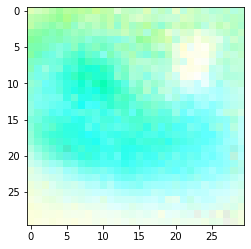

In [11]:
patch=get_patch(adv_img_list[img_id], 90, 100, 30, 30)
plt.imshow(patch)

(-0.5, 29.5, 29.5, -0.5)

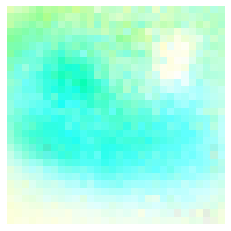

In [12]:
patch_new = np.copy(patch) 

plt.imshow(patch_new)
plt.axis('off')

In [13]:
new_trigger = torch.FloatTensor(np.transpose(patch_new, (2,0,1))).unsqueeze(0).cuda()
# Here we set the target class to be 2, which is the target class of this poisoned classifier
# start_x and start_y refers to the coordinate where the backdoor trigger (upper-left corner) will be applied
# Since for trojAI dataset, we are not aware of how the trigger is applied during training, here we apply those 
# alternative backdoors to a place near the center at the foreground object;
abc = test_model_under_patch(classifier, new_trigger, clf_id, target_class=2, start_x=100, start_y=100)

Accuracy under current trigger: 1.0000
